# RDS Homework 3 Template
## Spring 2023


In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from __future__ import print_function

import shap
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.ensemble
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Configs
np.random.seed(1)
shap.initjs()
sns.set_style("whitegrid")

plot_shap=True # NOTE: Turn False to disable shap plots as they can be slow to load 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Problem 3

### Part (A)

In [3]:
# Mark the categories of interest
categories = ['alt.atheism', 'soc.religion.christian']

# Fetch the data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

# Set outcome class names
class_names = ['atheism', 'christian']

In [4]:
import pandas as pd

df_train = pd.DataFrame({'text': newsgroups_train.data, 'label': newsgroups_train.target})
df_test = pd.DataFrame({'text': newsgroups_test.data, 'label': newsgroups_test.target})

In [5]:
# Initialize & fit tf-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, use_idf=True)
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_train.shape

(1079, 10665)

In [6]:
X_test = vectorizer.transform(newsgroups_test.data)
X_test.shape

(717, 10665)

In [7]:
# Train & fit the classifier 
from sklearn.metrics import accuracy_score
clf = SGDClassifier(loss='log_loss')
clf.fit(X_train,newsgroups_train.target)

SGDClassifier(loss='log_loss')

In [8]:
y_pred = clf.predict(X_test)

In [9]:
print(accuracy_score(newsgroups_test.target,y_pred))

0.9316596931659693


### Part (B)

In [10]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(newsgroups_test.target, y_pred)
print(cm)

[[274  45]
 [  4 394]]


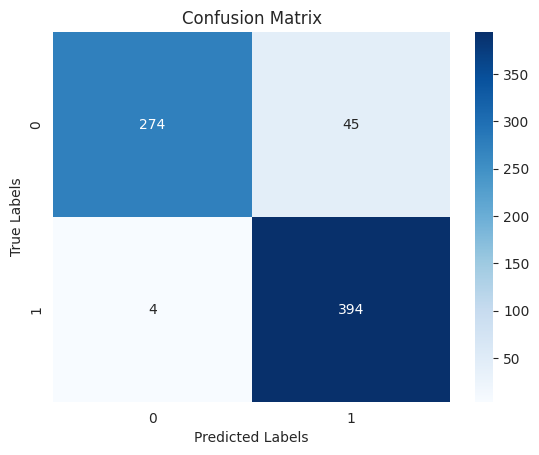

In [11]:
sns.heatmap(cm, annot=True, cmap='Blues',fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [12]:
len(y_pred)

717

Lets find some missclassified indexes.

In [13]:
k = len(y_pred) - 500
for i in range(k):
  if(y_pred[i] != newsgroups_test.target[i]):
    print(i)

25
38
54
62
94
99
107
109
123
126
134
156
197
216


#### Explainer

In [14]:
# Initialize the explainer and apply to test data
import shap
shap.initjs()
explainer = shap.LinearExplainer(clf,X_train)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


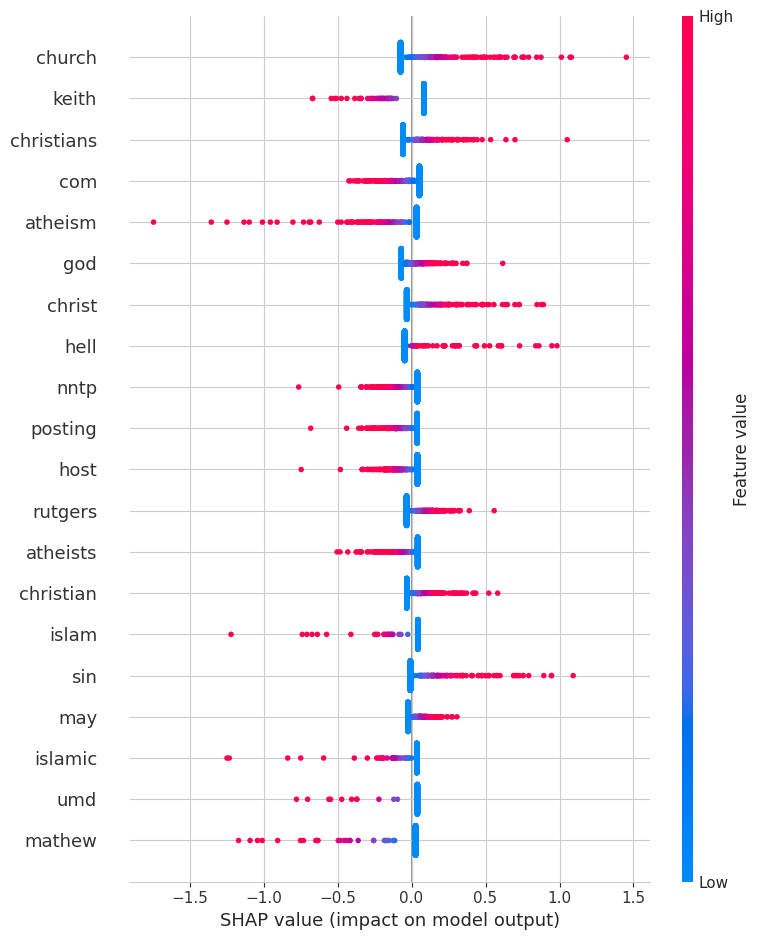

In [15]:
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.toarray() # We need to provide the data in dense format, not sparse
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names_out())

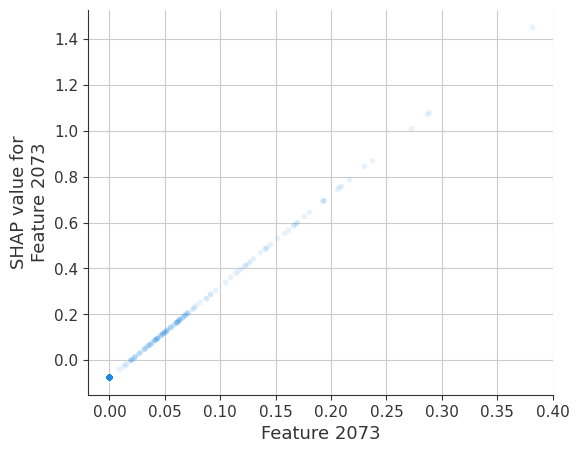

In [16]:
shap.dependence_plot(vectorizer.get_feature_names_out().tolist().index("church"), shap_values, X_test_array, alpha=0.1, interaction_index=None)

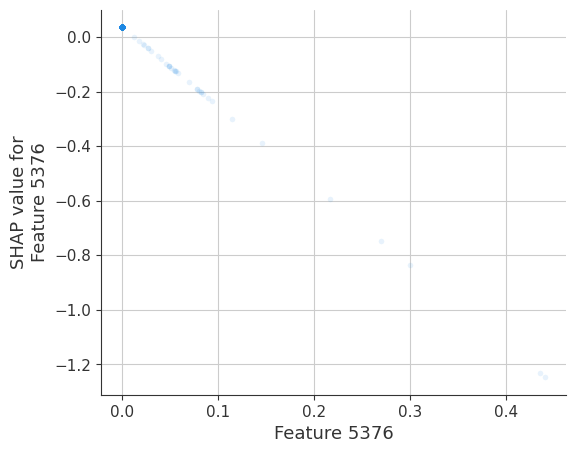

In [17]:
shap.dependence_plot(vectorizer.get_feature_names_out().tolist().index("islamic"), shap_values, X_test_array, alpha=0.1, interaction_index=None)

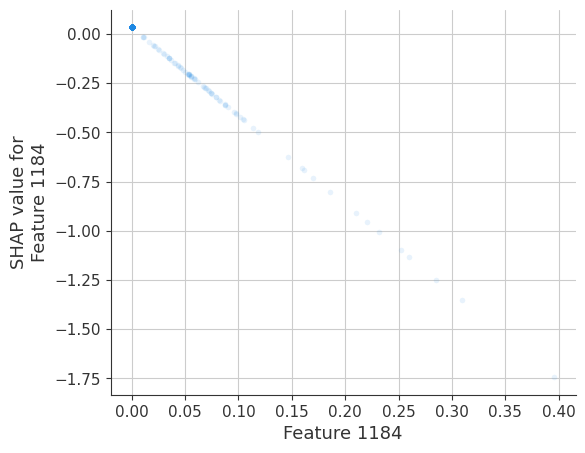

In [18]:
shap.dependence_plot(vectorizer.get_feature_names_out().tolist().index("atheism"), shap_values, X_test_array, alpha=0.1, interaction_index=None)

In [19]:
# Visually explain 5 documents selected from the test set
shap.initjs()
idx = 8
print("Christianity" if newsgroups_test.target[idx] else "Atheism")
print(newsgroups_test.data[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names_out()
)


Christianity
From: autry@magellan.stlouis.sgi.com (Larry Autry)
Subject: Definition of Christianity?
Organization: Silicon Graphics, St. Louis, MO
Lines: 84

I have enrolled in "The History of Christianity" at a college here in
St. Louis. The teacher of the class is what I consider to be
closed-minded and bigotted on the subject of what the definition of
Christianity is.  His definition is tied directly to that of the
Trinity and the Catholic church's definition of it and belief in
Jesus Christ is not sufficient to call one's self a Christian.

While his saying it doesn't make it so,  I nevertheless feel insulted
(or am I just neurotic? :^) ). I would like to be able to respond to
him with some sense of literacy while maintaining an amiable
student-teacher relationship.

So, is there common definition of what Christianity is?  As the
previous discussion of the Trinity did not lend itself to an exchange
of flames, I am hopeful that this will also not produce major
flames.

Regards,
--
L

##This index=8 is correctly classified as christianity.

In [20]:
shap.initjs()
idx = 54
print("Christianity" if newsgroups_test.target[idx] else "Atheism")
print(newsgroups_test.data[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names_out()
)

Christianity
From: mangoe@cs.umd.edu (Charley Wingate)
Subject: Hyslop and _The_Two_Babylons_
Lines: 9

Seeing as how _The_Two_Babylons_ has been brought up again, it is time for
me to respond , once again, and say that this book is junk.  It is nothing
more that an anti-Catholic tract of the sort published ever since the there
were protestants.  Its scholarship is phony and its assertions spurious.
-- 
C. Wingate        + "The peace of God, it is no peace,
                  +    but strife closed in the sod.
mangoe@cs.umd.edu +  Yet, brothers, pray for but one thing:
tove!mangoe       +    the marv'lous peace of God."



##This index=54 is missclassified as christianity while the outcome should be atheism as our shap value is lower than the base value

In [21]:
shap.initjs()
idx = 412
print("Christianity" if newsgroups_test.target[idx] else "Atheism")
print(newsgroups_test.data[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names_out()
)

Atheism
From: cobb@alexia.lis.uiuc.edu (Mike Cobb)
Subject: Re: Societally acceptable behavior
Organization: University of Illinois at Urbana
Lines: 20

I guess I'm delving into a religious language area.  What exactly is morality 
or morals?  I never thought of eating meat to be moral or immoral, but I think
it could be.  How do we differentiate between not doing something because it is
a personal choice or preference and not doing something because we see it as 
immoral?  Do we fall to what the basis of these morals are?

Also, consensus positions fall to a might makes right.  Or, as you brought out,
if whatever is right is what is societally mandated then whoever is in control
at the time makes what is right

MC
MAC
--
****************************************************************
                                                    Michael A. Cobb
 "...and I won't raise taxes on the middle     University of Illinois
    class to pay for my programs."                 Champaign-Urba

##This index=412 is correctly classified as atheism as the value is less thsan the base value.

In [22]:
shap.initjs()
idx = 21
print("Christianity" if newsgroups_test.target[idx] else "Atheism")
print(newsgroups_test.data[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names_out()
)

Christianity
From: dps@nasa.kodak.com (Dan Schaertel,,,)
Subject: Re: Homosexuality issues in Christianity
Reply-To: dps@nasa.kodak.com
Organization: Eastman Kodak Company
Lines: 30

In article 15441@geneva.rutgers.edu, loisc@microsoft.com (Lois Christiansen) writes:

|>You might visit some congregations of Christians, who happen to be homosexuals,
|>that are spirit-filled believers, not MCC'rs; before you go lumping us all
|>together with Troy Perry.  
|>

Gee, I think there are some real criminals (robbers, muderers, drug
addicts) who appear to be fun loving caring people too.  So what's
your point?  Is it OK. just because the people are nice?

|>Isn't Satan having a hayday pitting Christian against Christian over any issue
|>he can, especially homosexuality.  Let's reach the homosexuals for Christ. 
|>Let's not try to change them, just need to bring them to Christ.  If He
|>doesn't want them to be gay, He can change that.  If they are living a moral
|>life, committed to someone of t

##This index=21 is correctly classified as christianity.

In [23]:
shap.initjs()
idx = 0
print("Christianity" if newsgroups_test.target[idx] else "Atheism")
print(newsgroups_test.data[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names_out()
)

Christianity
From: crackle!dabbott@munnari.oz.au (NAME)
Subject: "Why I am not Bertrand Russell" (2nd request)
Reply-To: dabbott@augean.eleceng.adelaide.edu.au (Derek Abbott)
Organization: Electrical & Electronic Eng., University of Adelaide
Lines: 4

Could the guy who wrote the article "Why I am not Bertrand Russell"
resend me a copy?

Sorry, I accidently deleted my copy and forgot your name.



##This index=0 is missclassified as christianity while the outcome should be atheism as our shap value is lower than the base value

### Part (C)


#### Part (i)

In [24]:
# Compute the accuracy of the classifier and the number of misclassified documents

print("Accuracy of our Classifier : ",accuracy_score(newsgroups_test.target,y_pred))

Accuracy of our Classifier :  0.9316596931659693


In [25]:
from sklearn.metrics import zero_one_loss

print("Number of misclassified documents : ",zero_one_loss(newsgroups_test.target,y_pred,normalize=False))

Number of misclassified documents :  49


In [26]:
import numpy as np

misclassified_indexes = np.where(newsgroups_test.target != y_pred)
print(misclassified_indexes)

(array([ 25,  38,  54,  62,  94,  99, 107, 109, 123, 126, 134, 156, 197,
       216, 217, 245, 271, 280, 377, 399, 406, 413, 419, 438, 442, 447,
       460, 461, 469, 514, 558, 568, 581, 591, 607, 610, 615, 620, 623,
       630, 641, 658, 668, 677, 679, 683, 685, 694, 703]),)


In [27]:
prob_estimate = clf.predict_proba(X_train[25])
print(prob_estimate)

[[0.96271556 0.03728444]]


#### Part (ii)

In [28]:
# Calculate conf_i for all misclassified documents 
from sklearn.metrics import log_loss

conf_i_arr = []

for idx in misclassified_indexes[0]:
  prob_estimate = clf.predict_proba(X_train[idx])
  conf_i_arr.append(abs(prob_estimate[0][1] - prob_estimate[0][0]))

print(conf_i_arr)

[0.9254311205310441, 0.9127765769961504, 0.9098304218544482, 0.9166165957619974, 0.9772616171660093, 0.948118353776708, 0.9807106784212756, 0.807133129776201, 0.7528027467135754, 0.9196480738749391, 0.958891442082237, 0.9260632098518233, 0.9551702718422646, 0.7849593129764487, 0.8838807007073843, 0.9022816561670721, 0.9667712919045701, 0.9339893393713534, 0.8624069935211232, 0.7567637019670277, 0.5637350435981996, 0.7951274468870593, 0.9570851803498348, 0.9531550485967553, 0.8301660720640722, 0.9585502489464597, 0.9646067183034566, 0.8224582482034324, 0.7313875109640153, 0.9517502566085185, 0.8552568651328734, 0.7962848928874497, 0.9063080124443648, 0.861315239434405, 0.8615214497275472, 0.9785266087149713, 0.8507608476040063, 0.8066380197972014, 0.9042804287354982, 0.8013779242782717, 0.867358105416167, 0.8551739229045348, 0.9001819940698224, 0.9153185757648576, 0.8850865382387214, 0.9477609696242693, 0.8836455279160496, 0.9440331451452624, 0.8957872039635426]


(array([ 1.,  0.,  0.,  0.,  3.,  6.,  5.,  8., 12., 14.]),
 array([0.56373504, 0.60543261, 0.64713017, 0.68882773, 0.7305253 ,
        0.77222286, 0.81392042, 0.85561799, 0.89731555, 0.93901311,
        0.98071068]),
 <BarContainer object of 10 artists>)

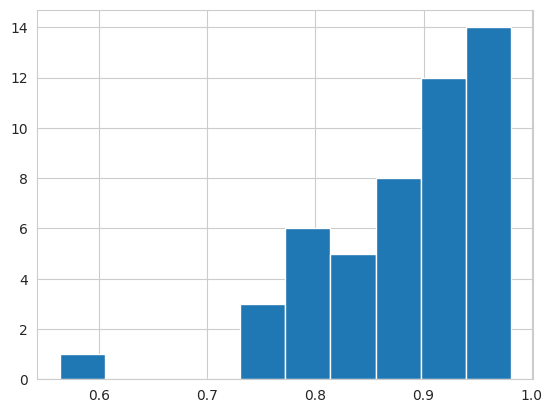

In [29]:
# Plot conf_i
plt.hist(conf_i_arr)


#### Part (iii)

In [30]:
# Identify tokens (word_j) that contributed to the misclassification of documents
X_test_miss = X_test_array[misclassified_indexes]
word_list = vectorizer.get_feature_names_out()
shap_values_miss = shap_values[misclassified_indexes]
y_pred_miss = y_pred[misclassified_indexes]


In [31]:
# Compute the number of documents (count_j) these words helped to misclassify
word_counts ={}
for doc in range(X_test_miss.shape[0]):
  for word in range(X_test_miss.shape[1]):
    if(shap_values_miss[doc,word] > 0 and y_pred_miss[doc]==1 and X_test_miss[doc][word]!=0) or (shap_values_miss[doc,word] < 0 and y_pred_miss[doc]==0 and X_test_miss[doc][word]!=0):
      word_counts[word_list[word]] = word_counts.get(word_list[word],0) + 1


In [32]:
# Compute the sum of absolute SHAP values (weight_j) for each word_j

words_weights = {}

for doc in range(X_test_miss.shape[0]):
  for word in range(X_test_miss.shape[1]):
    if(shap_values_miss[doc,word] > 0 and y_pred_miss[doc]==1 and X_test_miss[doc][word]!=0) or (shap_values_miss[doc,word] < 0 and y_pred_miss[doc]==0 and X_test_miss[doc][word]!=0):
      words_weights[word_list[word]] = words_weights.get(word_list[word],0) + abs(shap_values_miss[doc,word])


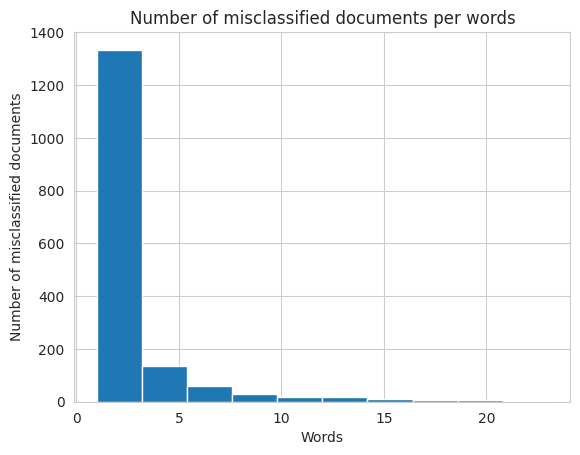

In [33]:
count_values = list(word_counts.values())
plt.hist(count_values, bins=10)

plt.xlabel('Words')
plt.ylabel('Number of misclassified documents')
plt.title('Number of misclassified documents per words')

plt.show()

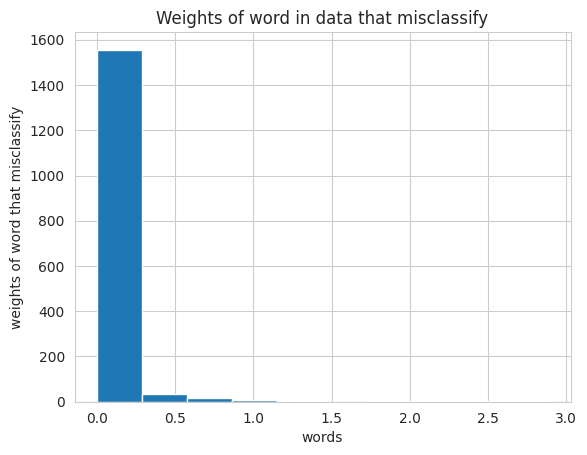

In [34]:
weights_words = list(words_weights.values())
plt.hist(weights_words, bins=10)

plt.xlabel('words')
plt.ylabel('weights of word that misclassify')
plt.title('Weights of word in data that misclassify')

plt.show()

### Part (D)

In [79]:
# Implement a strategy for feature selection
remove_words = []
for word,counts in word_counts.items():
  if(counts>10 and words_weights.get(word)>0.2):
    remove_words.append(word)

In [80]:
remove_words

['been',
 'other',
 'university',
 'will',
 'believe',
 'his',
 'know',
 'before',
 'christ',
 'had',
 'he',
 'jesus',
 'never',
 'god',
 'when',
 'christian',
 'my',
 'why',
 'am',
 'because',
 'him',
 'me',
 'mind',
 'reason']

In [81]:
import re
def custom_tokenizer(document):
    tokens = document.split()
    filtered_tokens = [token for token in tokens if token not in remove_words]
    return filtered_tokens

def custom_tokenizer2(doc):
    token_pattern = re.compile(r"(?u)\b\w\w+\b")
    return [token for token in token_pattern.findall(doc.lower()) if token not in remove_words]

vectorizer2 = TfidfVectorizer(tokenizer=custom_tokenizer2,max_df=0.5, min_df=2)
X_train2 = vectorizer2.fit_transform(newsgroups_train.data)
X_train2.shape

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'


(1079, 10641)

In [82]:
from sklearn.metrics import accuracy_score
clf2 = SGDClassifier(loss='log_loss')
clf2.fit(X_train2,newsgroups_train.target)

SGDClassifier(loss='log_loss')

In [83]:
X_test2 = vectorizer2.transform(newsgroups_test.data)
y_pred2 = clf2.predict(X_test2)
print("Improved Accuracy : ",accuracy_score(newsgroups_test.target,y_pred2))

Improved Accuracy :  0.9344490934449093


In [39]:
print(y_pred2[4],newsgroups_test.target[4])

1 0


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


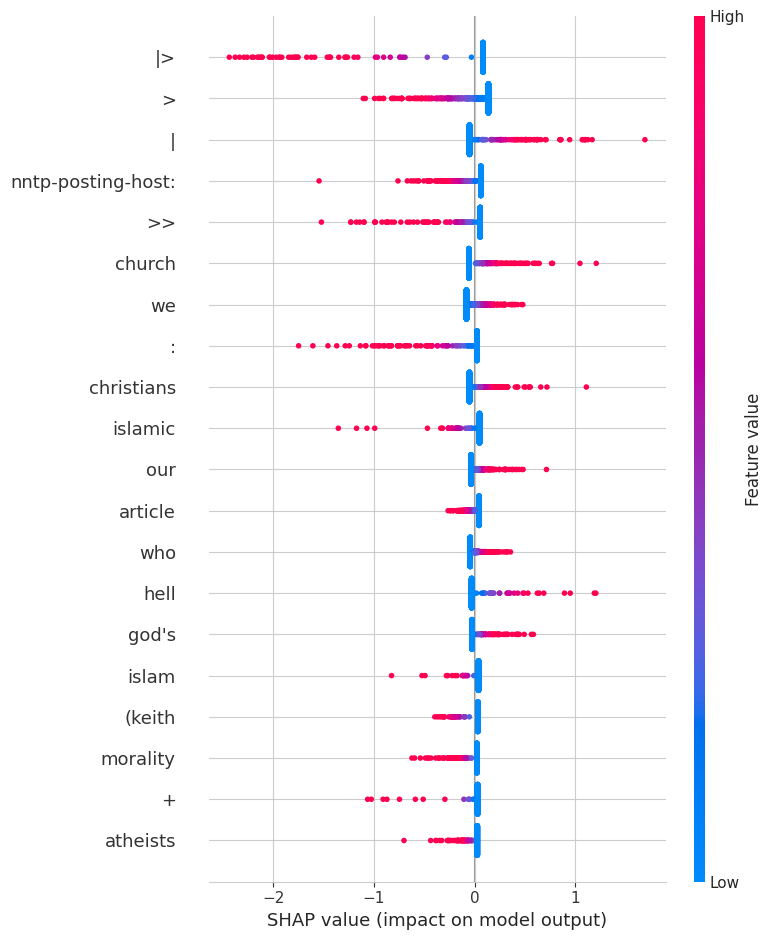

In [40]:
# Initialize the explainer and apply to test data
import shap
shap.initjs()
explainer2 = shap.LinearExplainer(clf2,X_train2)
shap_values2 = explainer2.shap_values(X_test2)
X_test_array2 = X_test2.toarray()
shap.summary_plot(shap_values2, X_test_array2, feature_names=vectorizer2.get_feature_names_out())

In [41]:
shap.initjs()
idx = 0
print("Christianity" if newsgroups_test.target[idx] else "Atheism")
print(newsgroups_test.data[idx])
shap.force_plot(
    explainer2.expected_value, shap_values2[idx,:], X_test_array2[idx,:],
    feature_names=vectorizer2.get_feature_names_out()
)

Christianity
From: crackle!dabbott@munnari.oz.au (NAME)
Subject: "Why I am not Bertrand Russell" (2nd request)
Reply-To: dabbott@augean.eleceng.adelaide.edu.au (Derek Abbott)
Organization: Electrical & Electronic Eng., University of Adelaide
Lines: 4

Could the guy who wrote the article "Why I am not Bertrand Russell"
resend me a copy?

Sorry, I accidently deleted my copy and forgot your name.



We can see that for the index 0 we get a correct classification unlike our previous classifer. 

In [42]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
cm2 = confusion_matrix(newsgroups_test.target, y_pred2)
print(cm)

[[274  45]
 [  4 394]]


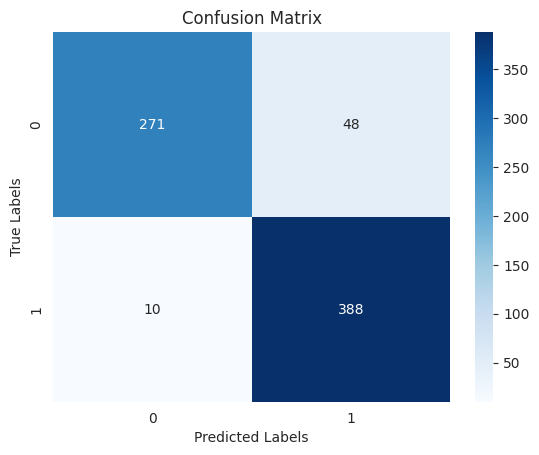

In [43]:
sns.heatmap(cm2, annot=True, cmap='Blues',fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()